<a href="https://colab.research.google.com/github/vithushanms/deep-neural-network-fundamentals/blob/main/back%20propagation%20fundamentals/002_artificial_neurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
import math
import random

# functions from previous notebook

In [2]:
def trace (root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

class Value:
  def __init__(self, data, _children=(), _op=(), label = ''):
    self.data = data
    self.prev = set(_children)
    self.grad = 0.0
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    return Value(self.data + other.data, (self, other), '+')

  def __mul__(self, other):
    return Value(self.data * other.data, (self, other), 'x')

# Understanding the backpropogation with a small baby neuron

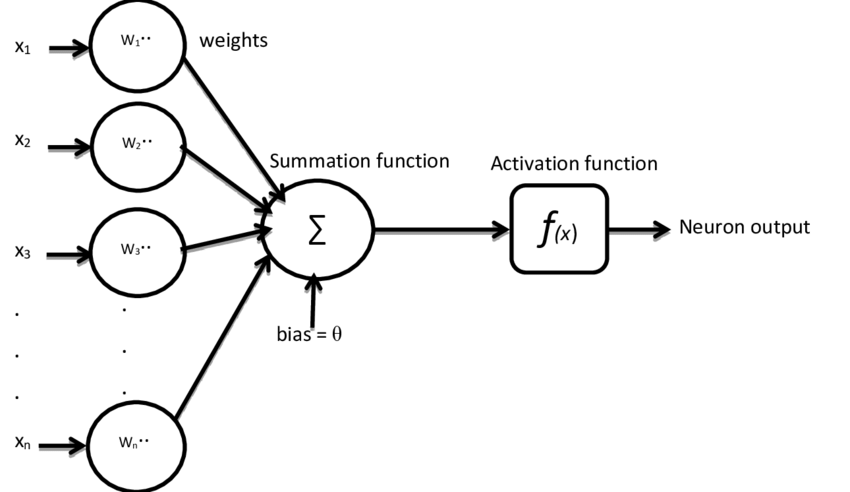

Analogy to the Biological Neuron

Imagine the biological neurons in your brain. They receive signals from other neurons, process those signals, and then transmit a new signal if certain conditions are met. An artificial neuron mimics this process.

Key Components of an Artificial Neuron

<b>Inputs</b>:  These are numerical values that the neuron receives.  Each input represents a piece of information from the previous layer of neurons (or the external world if it's the first layer).

<b>Weights</b>: Each input has an associated weight. This weight signifies the importance or strength of that particular input. Higher weights mean the input has a stronger influence on the neuron's decision.

<b>Bias</b>: The bias is a constant value added to the weighted sum of the inputs. It helps adjust the neuron's sensitivity. Think of it as the neuron's inherent tendency to fire or not.

<b>Summation Function</b>: The neuron calculates the weighted sum of its inputs and adds the bias. This is a simple linear combination:(Input1 * Weight1) + (Input2 * Weight2) + ... + Bias

<b>Activation Function</b>: This is where the magic happens. The activation function introduces non-linearity. It takes the weighted sum (plus bias) and transforms it into the neuron's output.

<b>The Neuron's Output</b>

The output of the activation function is the neuron's signal. This signal is passed on to the next layer of neurons or becomes the final output of the network.

## Example for pre-activation

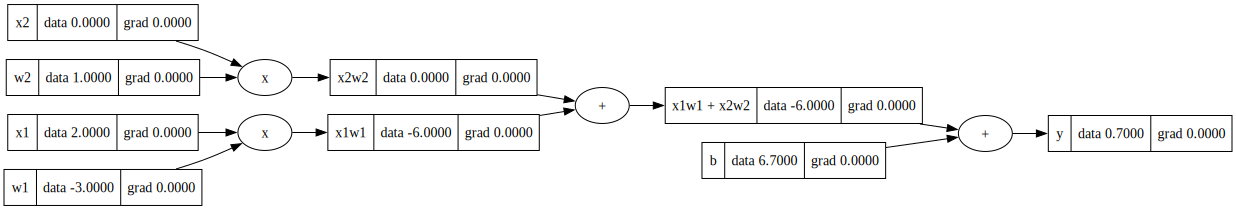

In [3]:
# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.7, label='b')

# output
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1 + x2w2'
y = x1w1_x2w2 + b; y.label = 'y'

draw_dot(y)

## Activation function example

this is most of the time squashing function.

### Tanh (Hyperbolic Tangent)

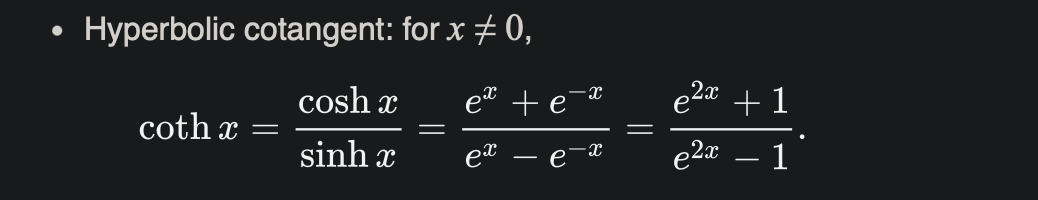

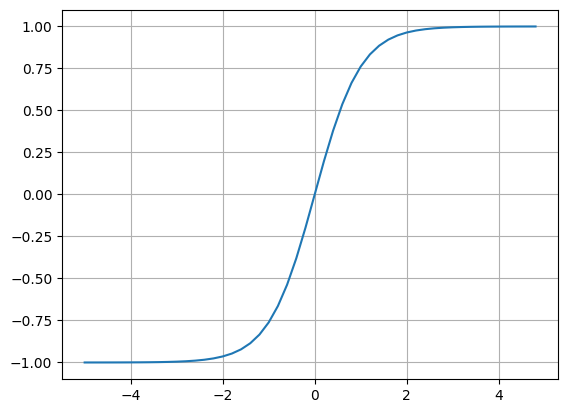

In [4]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid() # show grid lines

### Update Value class to have tanh activation function

In [5]:
class Value:
  def __init__(self, data, _children=(), _op=(), label = ''):
    self.data = data
    self.prev = set(_children)
    self.grad = 0.0
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    return Value(self.data + other.data, (self, other), '+')

  def __mul__(self, other):
    return Value(self.data * other.data, (self, other), 'x')
  
  def tanh(self):
    return Value(
      (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1),  
      (self,), 'tanh')
    

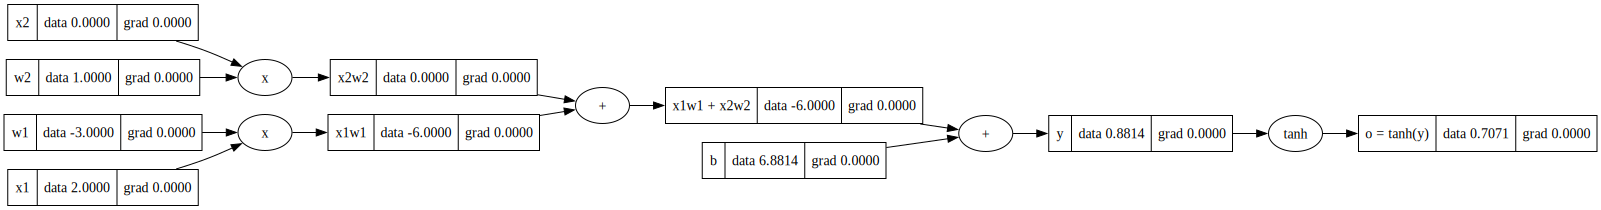

In [6]:
# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.88137, label='b')

# output
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1 + x2w2'
y = x1w1_x2w2 + b; y.label = 'y'
o = y.tanh(); o.label = 'o = tanh(y)'

draw_dot(o)

### Derivative of tanh function
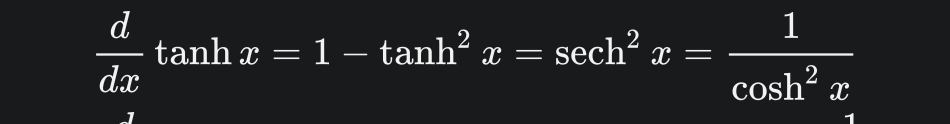

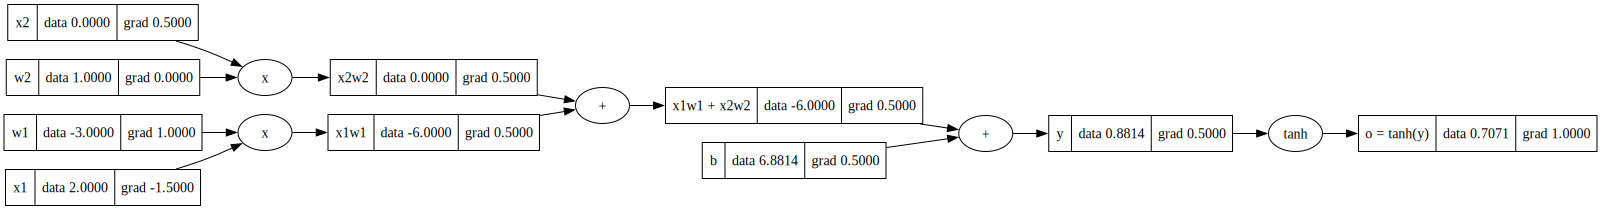

In [7]:
o.grad = 1.0

# dy / do = 1 - tanh(y)^2
y.grad = 1 - o.data**2
x1w1_x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
b.grad = 0.5
x1.grad = -3.0 * 0.5
w1.grad = 2.0 * 0.5
x2.grad = 1.0 * 0.5
w2.grad = 0.0 * 0.5
draw_dot(o)

# Automatic Backpropagation

In [8]:
class Value:
  def __init__(self, data, _children=(), _op=(), label = ''):
    self.data = data
    self.prev = set(_children)
    self.grad = 0.0
    self._op = _op
    self.label = label
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
        self.grad += 1.0 * out.grad # += because multiple children can add to the gradient
        other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), 'x')
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __rmul__(self, other):
    return self * other
  
  def __radd__(self, other):
    return self + other
  
  def exp(self):
    out = Value(math.exp(self.data), (self,), 'exp')
    def _backward():
        self.grad += out.data * out.grad
    out._backward = _backward
    return out
  
  def __sub__(self, other):
    return self + (-other)
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float for now"
    out = Value(self.data ** other, (self,), f'pow of {other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out
  
  def __truediv__(self, other):
    return self * other**-1
  
  def __neg__(self):
    return self * -1
  
  def tanh(self):
    out = Value(
      (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1),  
      (self,), 'tanh')
    def _backward():
        self.grad += (1 - out.data**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
      


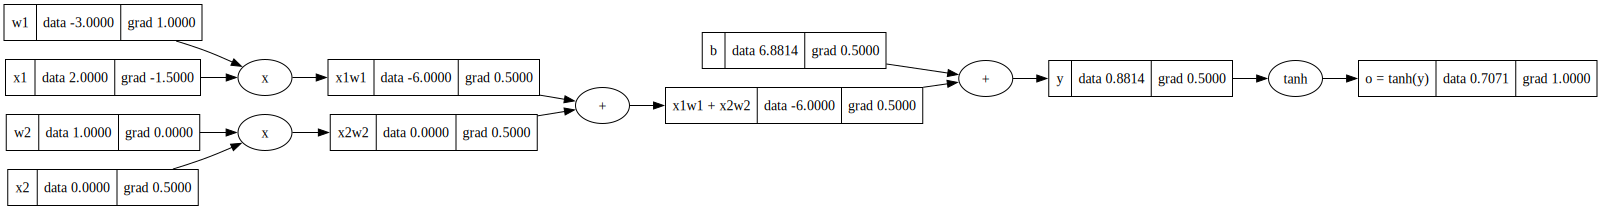

In [9]:
# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.88137, label='b')

# output
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1 + x2w2'
y = x1w1_x2w2 + b; y.label = 'y'
o = y.tanh(); o.label = 'o = tanh(y)'

#-------------------------
# o.grad = 1.0
# o._backward()
# y._backward()
# x1w1_x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# b._backward()
# x1._backward()
# w1._backward()
# x2._backward()
# w2._backward() 
#------------------------- the commented lines got replaced with topoligical sort implementation in the backward function of Value class

o.backward()

draw_dot(o)

### tanh in detail


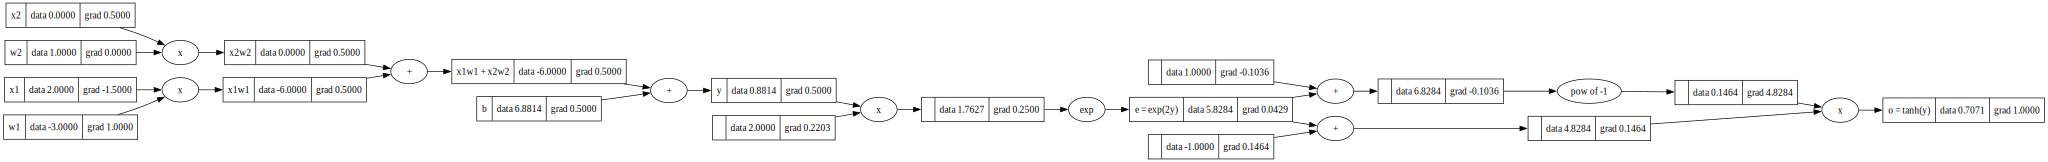

In [10]:
# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.88137, label='b')

# output
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1 + x2w2'
y = x1w1_x2w2 + b; y.label = 'y'

e = (2*y).exp(); e.label = 'e = exp(2y)'

o = (e-1)/(e+1); o.label = 'o = tanh(y)'
o.backward()

draw_dot(o)

# Neuron Class

In [13]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        preac = sum([xi*wi for xi,wi in zip(x, self.w)], self.b)
        out = preac.tanh()
        return out
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        return [n(x) for n in self.neurons]
    
class MLP:
    def __self__(self, nin, nouts):
        layer_sizes = [nin] + nouts
        self.layers = [Layer(i, i+1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    
x = [Value(random.uniform(-1,1)) for _ in range(2)]
n = Neuron(2)
n(x)
        

Value(data=-0.23718782155200432)